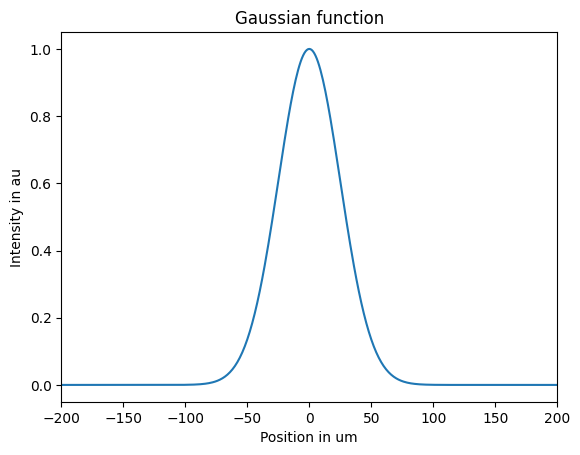

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# copied from above 

def propTF(uin_V_m, L_m, lambda_m, z_m):
    M = uin_V_m.size        # number of samples (grid points)
    dx_m = L_m/M            # grid spacing
    k_1_m = 2*np.pi/lambda_m # wavenumber

    # Frequency coordinates
    fx_1_m = np.linspace(-1/(2*dx_m), 1/(2*dx_m) - (1/L_m), M)
    
    # Transfer function for Fresnel propagation
    H = np.exp(-1j * np.pi * lambda_m * z_m * (fx_1_m**2))
    H = np.fft.fftshift(H)

    # Fourier transform input field
    Uin_V_m = np.fft.fft(np.fft.fftshift(uin_V_m))

    # Multiply in Fourier space
    Uout_V_m = H * Uin_V_m

    # Inverse FFT → propagated field
    uout_V_m = np.fft.ifftshift(np.fft.ifft(Uout_V_m))
    return uout_V_m


dx_m = 1e-6 #grid size, m:meter
Dx_m = 1 #screen size
x_m = np.linspace(-Dx_m/2, Dx_m/2, int(Dx_m/dx_m)+1)

x_mean_m = 0.0 #centered on...
x_std_m = 25e-6 #widthofgaussian
g = np.exp(-(x_m - x_mean_m)**2/(2*(x_std_m**2))) # gaussian intensity distribution 
plt.plot(x_m*1e6, g)
plt.xlabel("Position in um")
plt.ylabel("Intensity in au") #arbitrary units
plt.title("Gaussian function")
plt.xlim(-200, 200)
plt.show()

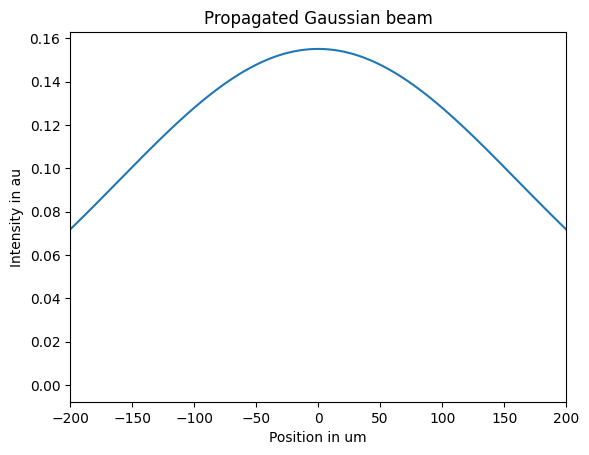

In [13]:
#initial beam electric field

wavelength_m = 500e-9 #wavelength, m
zp_m = 100e-3 #propagation distance, m

E0 = np.sqrt(g) # initial field amplitude squared equals the Gaussian intensity defined earlier 
Ep = propTF(E0, Dx_m, wavelength_m, zp_m) # propTF propagates that field forward by a distance zp_m 

Ip = np.abs(Ep)**2 # intensity 

plt.plot(x_m*1e6, Ip)
plt.xlabel("Position in um")
plt.ylabel("Intensity in au") #arbitrary units
plt.title("Propagated Gaussian beam")
plt.xlim(-200, 200)
plt.show()


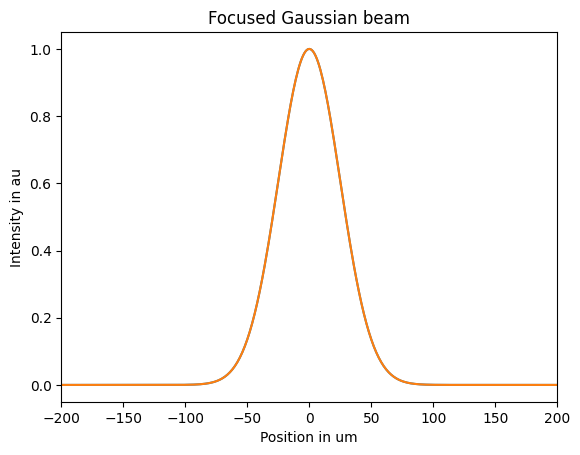

0.1


In [14]:
# Lens equation: 1/f_m = 1/p_m+1/q_m
# Lens phase: exp(i*(2*pi/lambda_m)/(2*f_m)*x_m^2)



p_m = zp_m 
q_m = zp_m 
f_m = 1/(1/(p_m) + (1/q_m)) #f_m = focal length, p_m = z_pm

lens = np.exp(-1j*(2*np.pi/wavelength_m)/(2*f_m)*x_m**2)

Ef = propTF(Ep*lens, Dx_m, wavelength_m, zp_m) 

plt.plot(x_m*1e6, np.abs(Ef)**2)
plt.plot(x_m*1e6, np.abs(E0)**2)
plt.xlabel("Position in um")
plt.ylabel("Intensity in au")
plt.title("Focused Gaussian beam")
plt.xlim(-200, 200)
plt.show()

print(zp_m)

<function matplotlib.pyplot.show(close=None, block=None)>

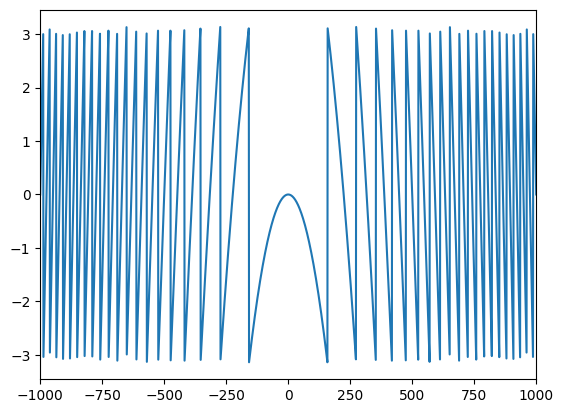

In [15]:
plt.plot(x_m*1e6, np.angle(lens))
plt.xlim(-1000,1000)
plt.show

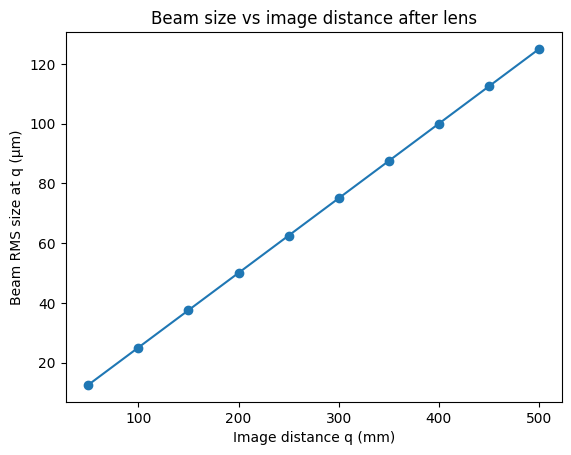

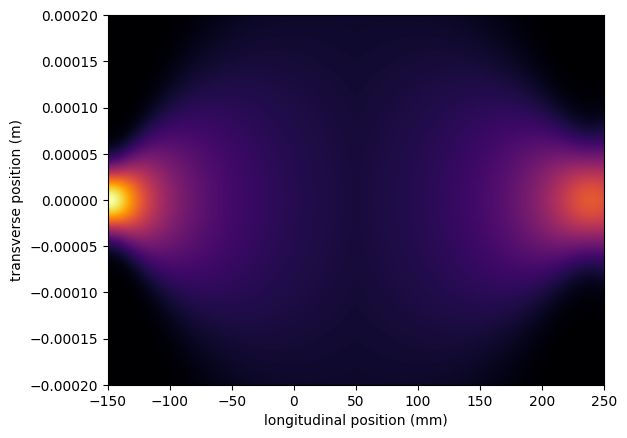

Initial RMS beam size: 25.00 µm
Focused RMS beam size: 41.67 µm
Ratio (initial/focused): 0.60


In [17]:
# focus at various distances (q and p diff)
# how beam size decr at diff q's

wavelength_m = 500e-9
dx_m = 1e-6
Dx_m = 1
x_m = np.linspace(-Dx_m/2, Dx_m/2, int(Dx_m/dx_m)+1)
x_mean_m = 0.0
x_std_m = 25e-6
g = np.exp(-(x_m - x_mean_m)**2/(2*(x_std_m**2)))
E0 = np.sqrt(g)

p_m = 0.1  # 0.1 m before lens
Ep = propTF(E0, Dx_m, wavelength_m, p_m)

# Try different image distances q_m after lens
q_m_list = np.linspace(0.05, 0.5, 10)  # 0.05 m to 0.5 m after lens
beam_sizes = []

for q_m in q_m_list:
    # Lens focal length from lens equation
    f_m = 1/(1/p_m + 1/q_m)
    lens = np.exp(-1j*(2*np.pi/wavelength_m)/(2*f_m)*x_m**2)
    # Field just after lens
    E_after_lens = Ep * lens
    # Propagate to image (distance q_m after lens)
    Ef = propTF(E_after_lens, Dx_m, wavelength_m, q_m)
    I_f = np.abs(Ef)**2
    # Compute RMS beam size image
    x_mean = np.sum(x_m * I_f) / np.sum(I_f)
    x_std = np.sqrt(np.sum((x_m - x_mean)**2 * I_f) / np.sum(I_f))
    beam_sizes.append(x_std * 1e6)  # micrometers 

plt.plot(q_m_list*1e3, beam_sizes, 'o-')
plt.xlabel("Image distance q (mm)")
plt.ylabel("Beam RMS size at q (µm)")
plt.title("Beam size vs image distance after lens")
plt.show()


# zp now q
# ratio, initial vs diff beam sizes 
# imshow plot but both sides of lens (loop before & after lens)

p_m = 0.15  # distance before lens
q_m = 0.25  # distance after lens
f_m = 1/(1/p_m + 1/q_m)

# before lens (negative), after lens (positive)
z_before = np.linspace(-p_m, 0, 100)
z_after = np.linspace(0, q_m, 100)
z_all = np.concatenate((z_before, z_after[1:])) 

I_zx = []

for z in z_all:
    if z < 0:
        # Propagate from source to just before lens
        Ep = propTF(E0, Dx_m, wavelength_m, z + p_m)
        I_zx.append(np.abs(Ep)**2)
    elif z == 0:
        # At the lens: apply lens phase
        Ep = propTF(E0, Dx_m, wavelength_m, p_m)
        Ep_lens = Ep * np.exp(-1j*(2*np.pi/wavelength_m)/(2*f_m)*x_m**2)
        I_zx.append(np.abs(Ep_lens)**2)
        E_after_lens = Ep_lens
    else:
        # After lens: propagate from lens
        Ep = propTF(E_after_lens, Dx_m, wavelength_m, z)
        I_zx.append(np.abs(Ep)**2)

# I_zx = np.array(I_zx)
# I_zx = I_zx / I_zx.max()  

# plt.figure(figsize=(8, 5))
# plt.imshow(I_zx, extent=[x_m[0]*1e3, x_m[-1]*1e3, z_all[0]*1e3, z_all[-1]*1e3],
#            aspect='auto', cmap='inferno', origin='lower')
# plt.colorbar(label="Normalized Intensity")
# plt.xlabel("x (mm)")
# plt.ylabel("z (mm)")
# plt.title("Beam propagation before and after lens")
# plt.show()


plt.imshow(np.transpose(I_zx),
           extent=[z_all[0]*1e3, z_all[-1]*1e3,x_m[0], x_m[-1]],
           aspect='auto',
           cmap='inferno')
plt.ylim([-0.0002, 0.0002])
plt.xlabel("longitudinal position (mm)")
plt.ylabel("transverse position (m)")
plt.xlim([-150,250])
plt.show()            


# Ratio of initial to focused beam size
Ep_focus = propTF(E_after_lens, Dx_m, wavelength_m, q_m)
I_focus = np.abs(Ep_focus)**2
x_mean_init = np.sum(x_m * np.abs(E0)**2) / np.sum(np.abs(E0)**2)
x_std_init = np.sqrt(np.sum((x_m - x_mean_init)**2 * np.abs(E0)**2) / np.sum(np.abs(E0)**2))
x_mean_focus = np.sum(x_m * I_focus) / np.sum(I_focus)
x_std_focus = np.sqrt(np.sum((x_m - x_mean_focus)**2 * I_focus) / np.sum(I_focus))
ratio = x_std_init / x_std_focus

print(f"Initial RMS beam size: {x_std_init*1e6:.2f} µm")
print(f"Focused RMS beam size: {x_std_focus*1e6:.2f} µm")
print(f"Ratio (initial/focused): {ratio:.2f}")

# Lens equation: 1/f_m = 1/p_m+1/q_m
# Lens phase: exp(i*(2*pi/lambda_m)/(2*f_m)*x_m^2)



# p_m = zp_m 
# q_m = zp_m 
# f_m = 1/(1/(p_m) + (1/q_m)) #f_m = focal length, p_m = z_pm

# lens = np.exp(-1j*(2*np.pi/wavelength_m)/(2*f_m)*x_m**2)

# Ef = propTF(Ep*lens, Dx_m, wavelength_m, q_m) 

# plt.plot(x_m*1e6, np.abs(Ef)**2)
# plt.plot(x_m*1e6, np.abs(E0)**2)
# plt.xlabel("Position in um")
# plt.ylabel("Intensity in au")
# plt.title("Focused Gaussian beam")
# plt.xlim(-200, 200)
# plt.show()

# print(zp_m)